# 2019 2nd ML month with KaKR
# 캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction
https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr/overview

## 라이브러리 import

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 필요한 라이브러리 가져오기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 라이브러리 버전 확인
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


In [4]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 1. 데이터 탐색

In [5]:
print(train.shape)
print(test.shape)

# 학습 데이터는 15035개의 데이터가 각각 21개의 컬럼을 가지며
# 테스트 데이터는 6468개의 데이터의 각각 20개의 컬럼을 가진다(price가 빠짐: target)

(15035, 21)
(6468, 20)


In [6]:
# 데이터를 살펴보자
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)    # date를 정수형 데이터로 >> 예측에 활용하기 위해서
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
train.info()
# train.dtypes로도 확인할 수 있다

# 모든 데이터가 정수, 실수형의 데이터를 가지는 것을 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int64  
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)    # test에서도 마찬가지로 date를 정수형 데이터로 >> 예측에 활용하기 위해서
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   int64  
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

### 변수 설명
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : Has been viewed
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
- sqft_lot15 : 근처 15가구의 부지, 평방 피트

### 목적변수(price) 확인

In [11]:
# 상세정보 확인
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

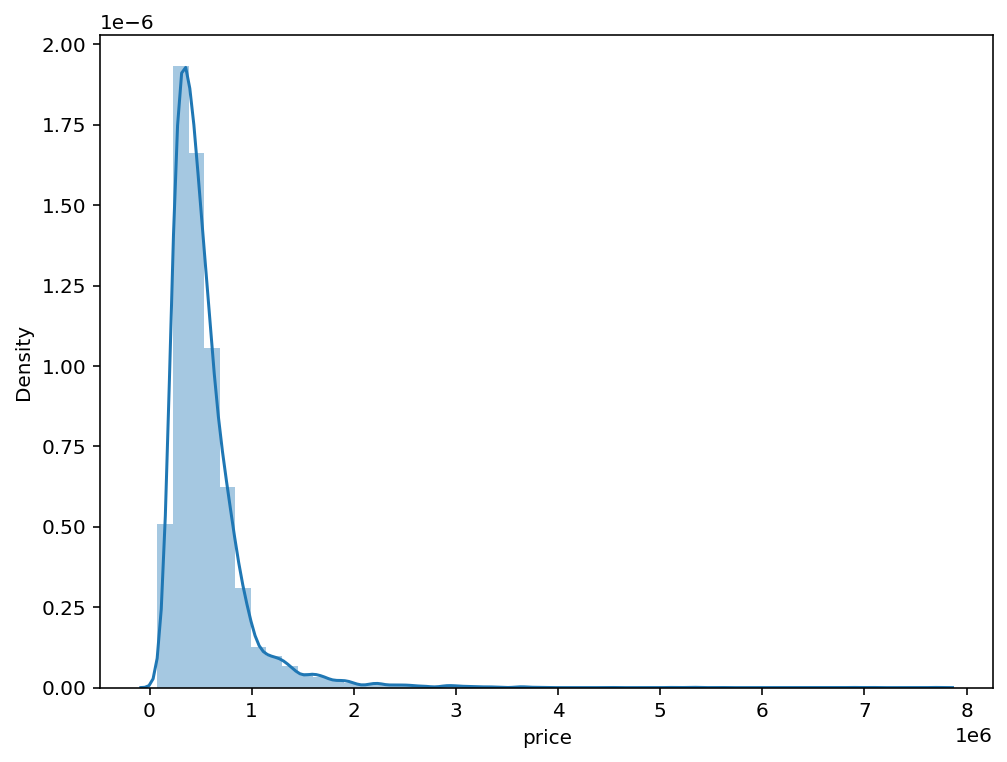

In [12]:
# 히스토그램으로 분포 확인
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

In [13]:
# skewness(왜도) and kurtosis(첨도) 확인
print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

# 정규분포 기준으로 skewness가 0, kurtosis가 3이므로, 상당히 치우쳐 있다는 것을 알 수 있다.

Skewness: 4.290252
Kurtosis: 40.154919


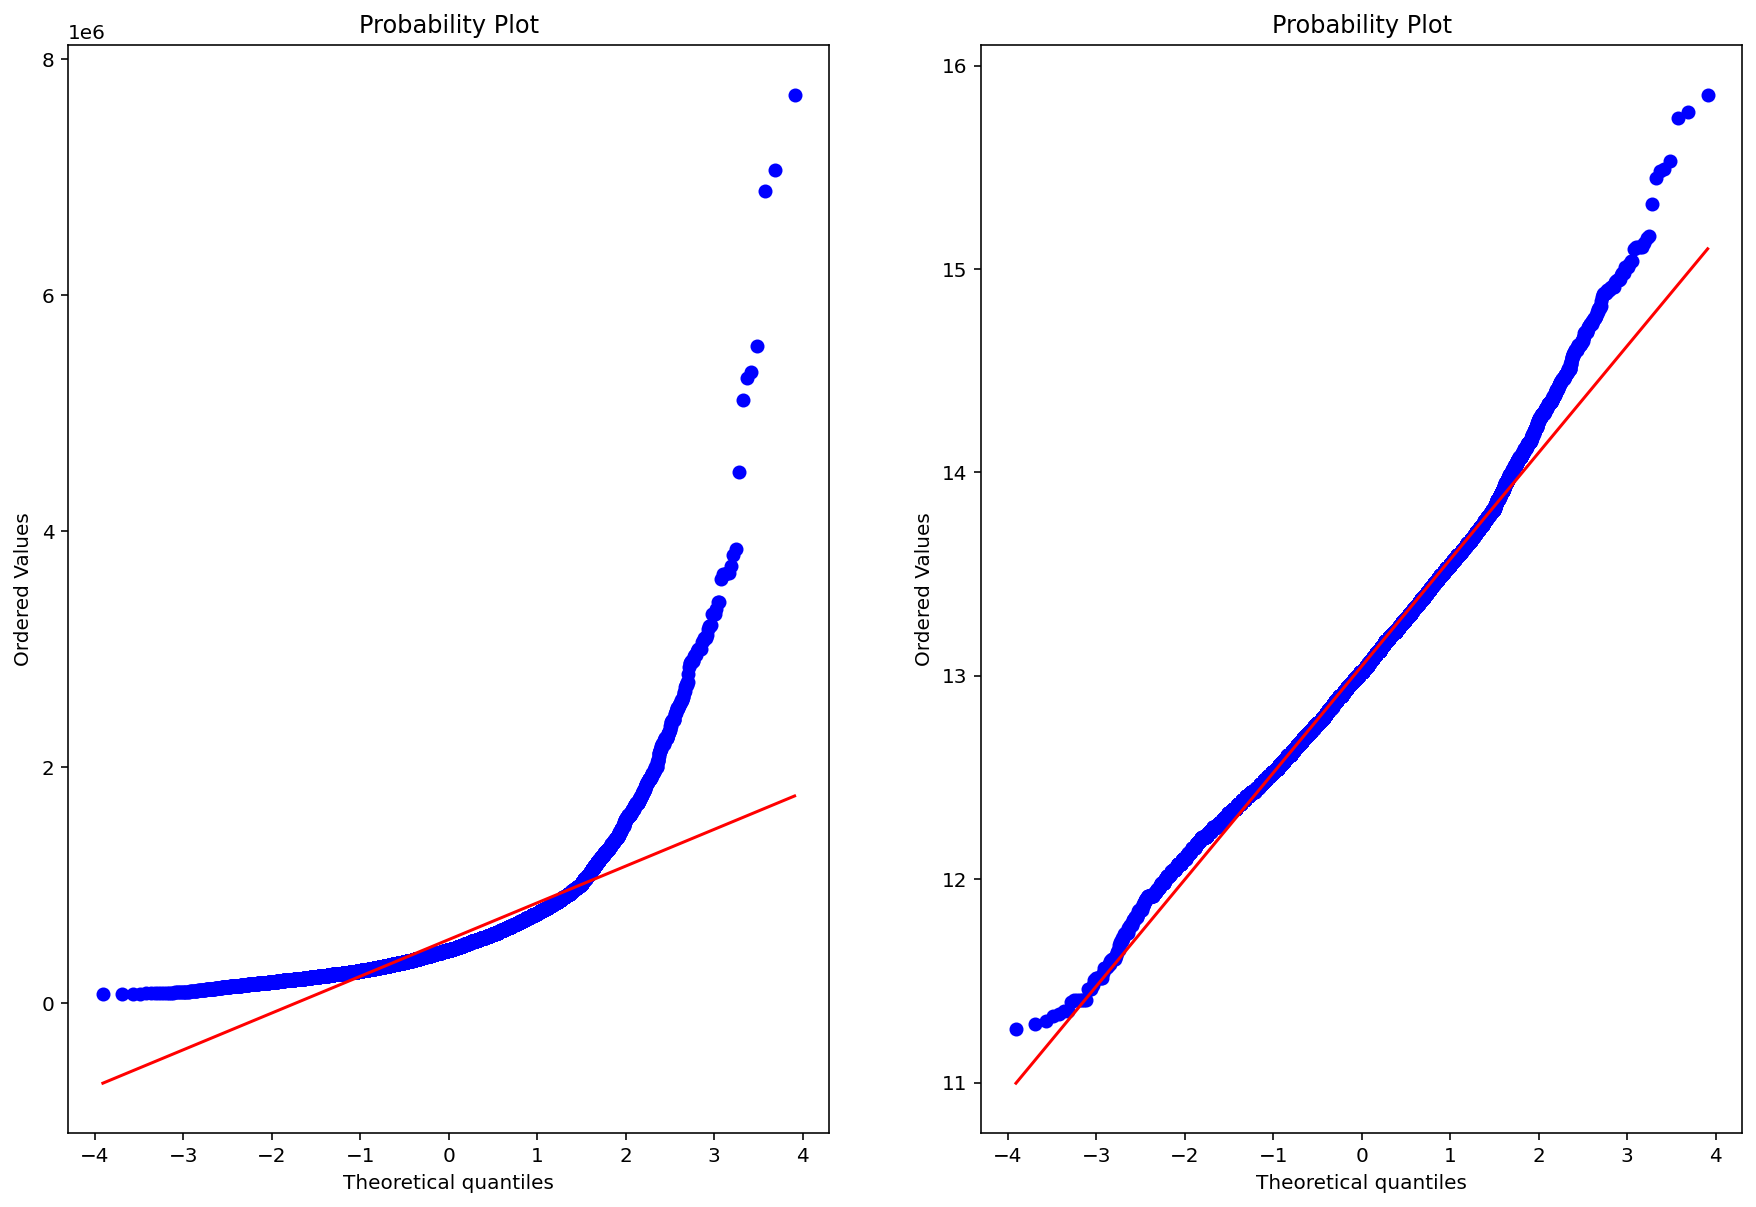

In [14]:
from scipy.stats import norm
from scipy import stats #Analysis

fig = plt.figure(figsize = (15,10))

# 로그 변환 전
fig.add_subplot(1,2,1)
res = stats.probplot(train['price'], plot=plt)

train['price'] = np.log1p(train['price'])

# 로그 변환 후
fig.add_subplot(1,2,2)
res = stats.probplot(train['price'], plot=plt)

<AxesSubplot:xlabel='price', ylabel='Density'>

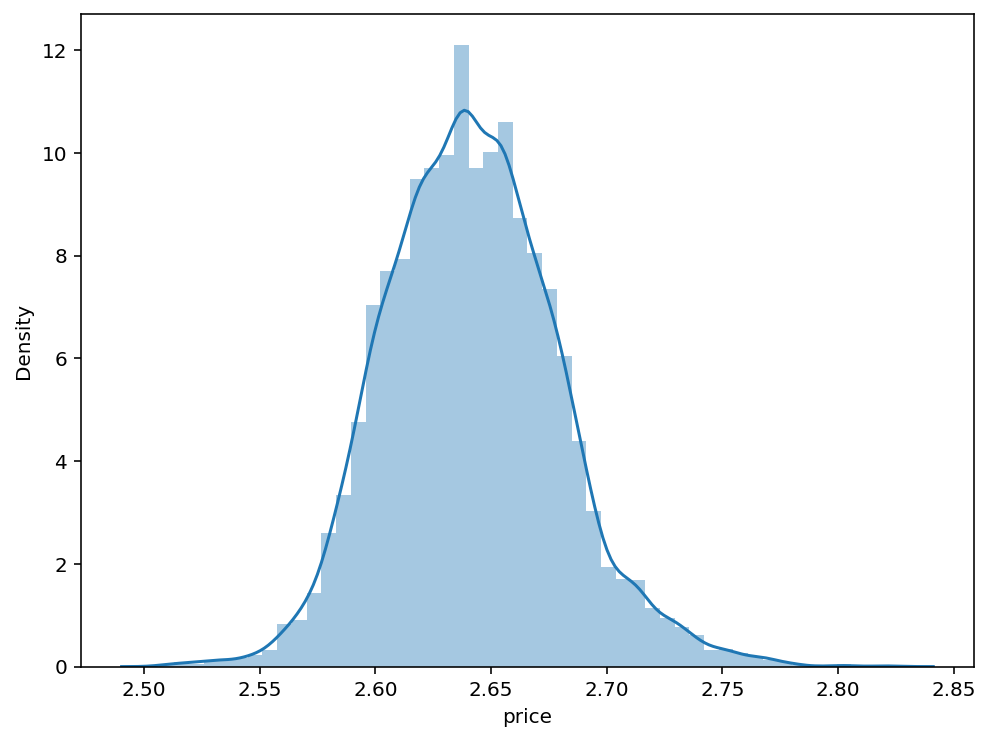

In [15]:
# 로그함수로 정규화해서 다시 히스토그램 그리기
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(np.log1p(train['price']))

### 변수시각화 (반응 변수)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode' 'date']


<AxesSubplot:>

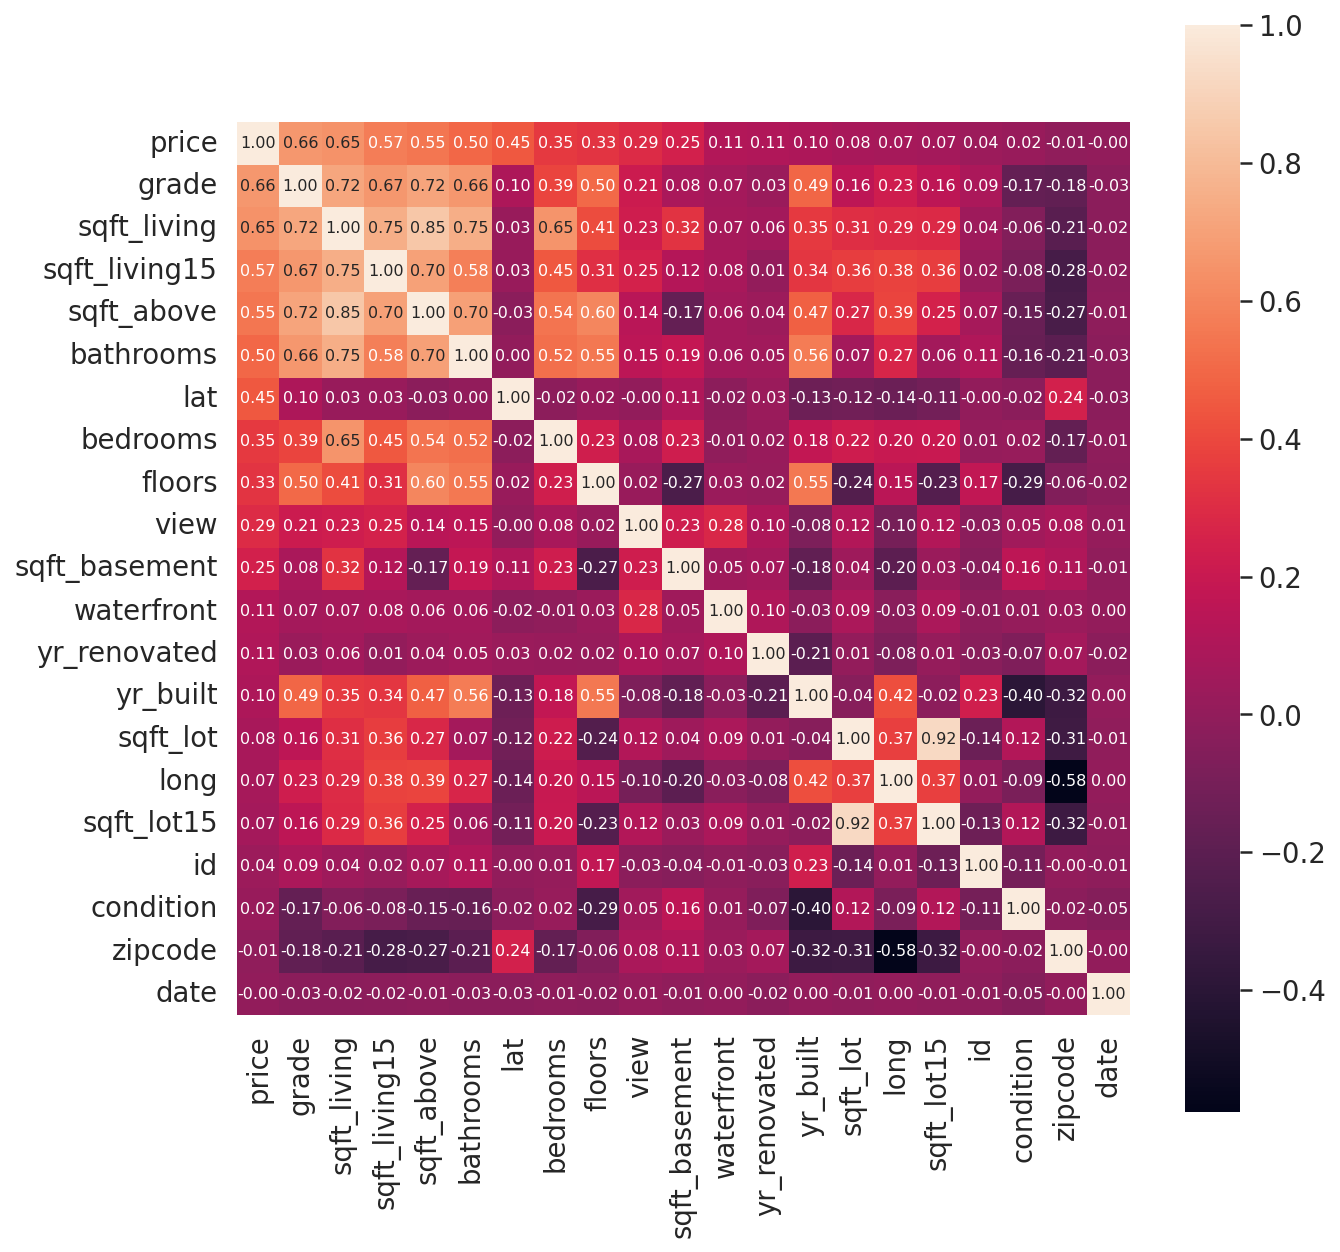

In [16]:
### 히트맵으로 price와 다른 변수들 간의 상관관계 확인
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함 
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=len(train.index), columns='price').index # 상관관계 내림차순 정렬
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

목적변수와 상관도가 높은 변수는 grade(집의 등급) - sqft_living(주거공간의 면적) - sqft_living15(근처 15 가구의 주거 공간) 순으로 나타난다. <br>
반대로 상관도가 낮은 변수는 date - zipcode 변수로, 음의 상관관계를 보이는 것을 알 수 있다.

In [17]:
# price(목적변수)와 음의 상관관계인 변수 삭제
train.drop(['date', 'zipcode'], axis=1, inplace=True)
test.drop(['date', 'zipcode'], axis=1, inplace=True)
train

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,0,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,1,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,2,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
3,3,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
4,4,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,13.322338,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,47.5137,-122.167,2520,6023
15031,15031,13.822984,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,47.5537,-122.398,2050,6200
15032,15032,12.793862,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,47.6993,-122.346,1530,1509
15033,15033,12.899222,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,47.5107,-122.362,1830,7200


### 결측치 확인

<AxesSubplot:>

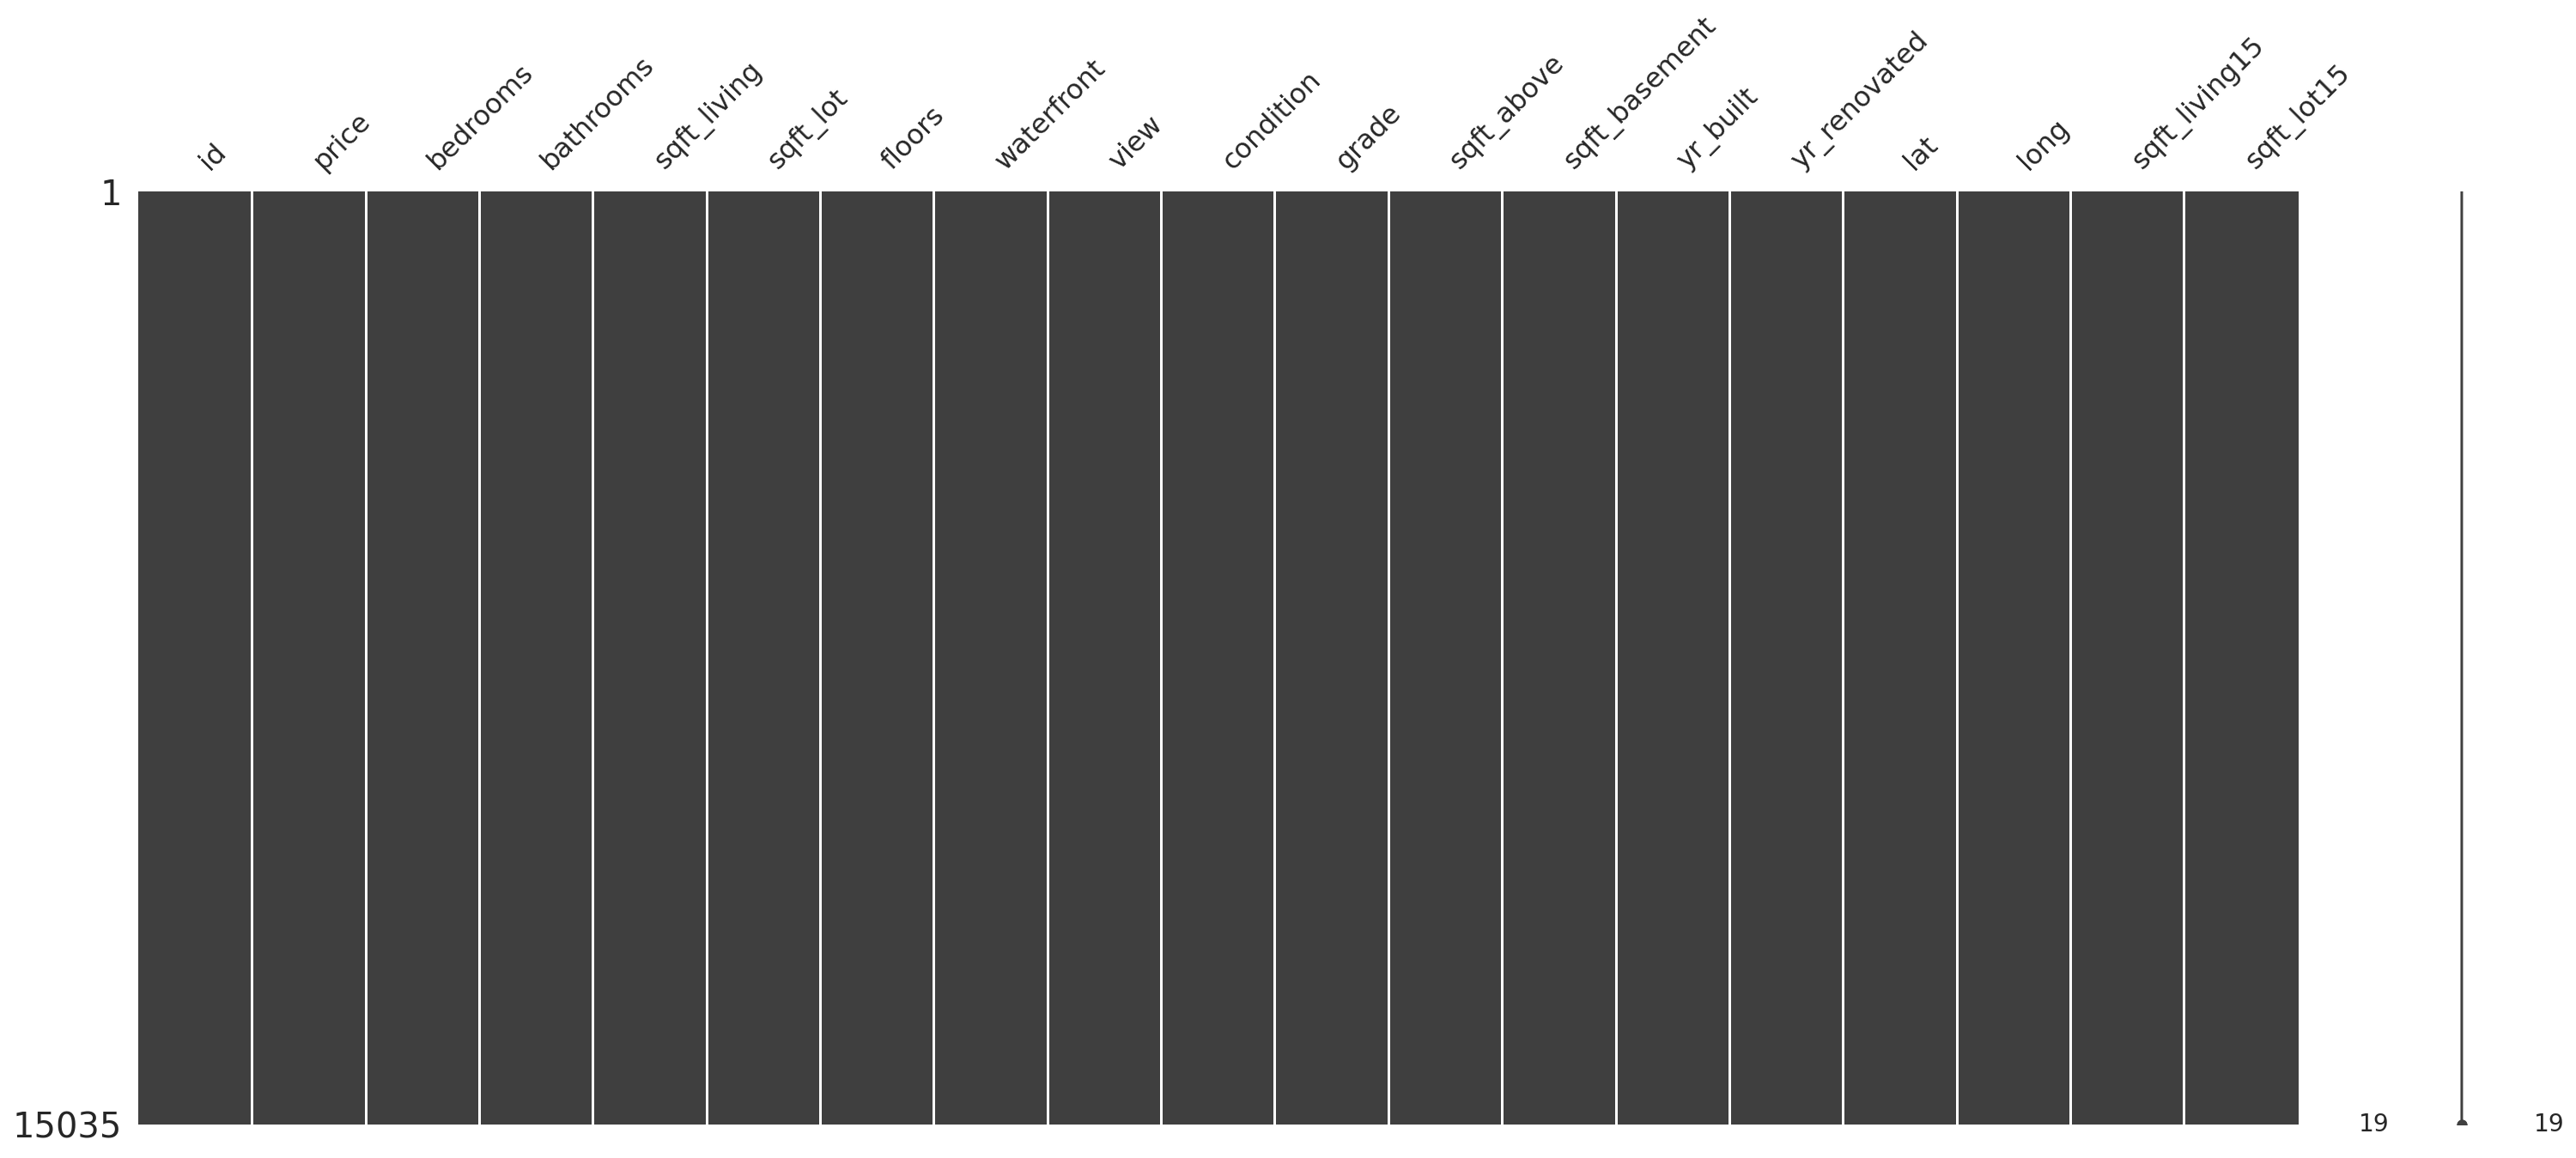

In [18]:
# 결측치 확인
msno.matrix(train)

# 매트릭스 전체가 까맣게 나온 것을 보니 결측치가 없는 것으로 보인다

In [19]:
# 상세 결측치 재확인
print(train.isnull().sum())

# 결측치 없음

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


## 2. 데이터 전처리

### 이상치 제거

위에서 살펴본 상관성이 높은 변수 grade, sqft_living에서 이상치를 확인해본다.

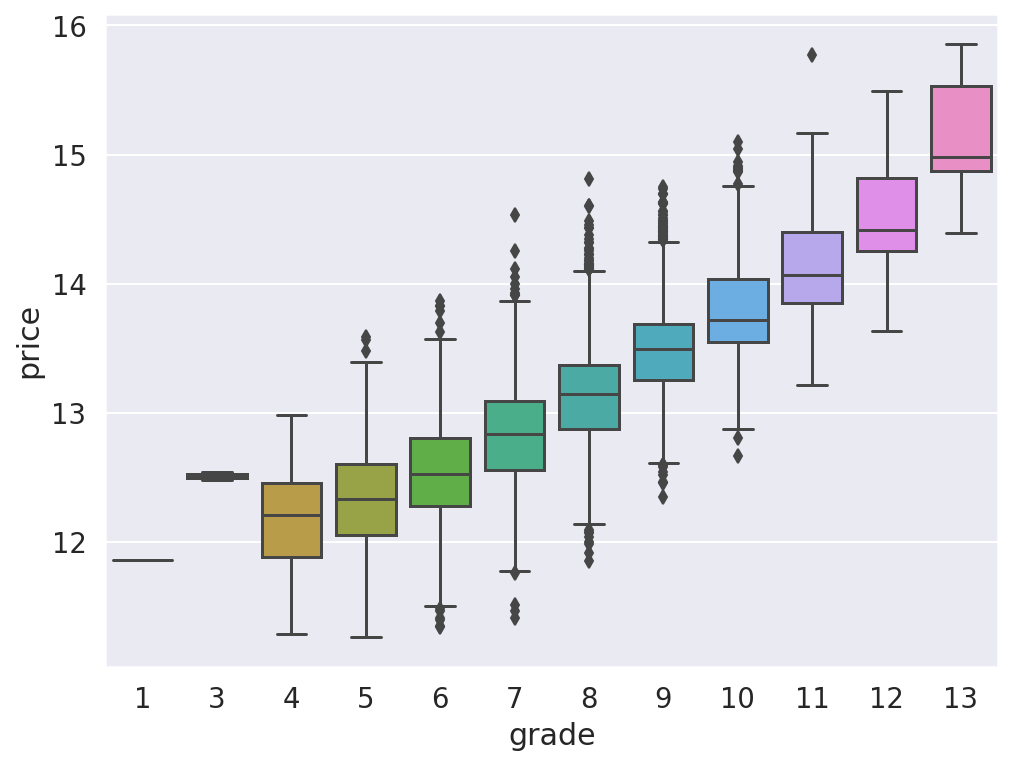

In [20]:
# price와 grade 재확인
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

전반적으로 집의 등급(grade)가 좋아지면 가격이 상승하는 상승곡선의 형태를 보인다.<br>

그러나 눈에 띄는 몇몇 항목을 살펴보자.

In [21]:
# 등급 3의 이상치 살펴보기
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
2302,2302,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,47.2082,-121.995,1340,12233
4123,4123,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,47.5316,-121.749,990,22549


In [22]:
# 등급 8의 이상치 살펴보기
train.loc[(train['price']>14.7) & (train['grade'] == 8)]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
7173,7173,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,47.6803,-122.214,2660,27295


In [23]:
# 등급 11의 이상치 살펴보기
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
2775,2775,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,47.65,-122.214,3930,25449


In [24]:
# 이상치 삭제
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]

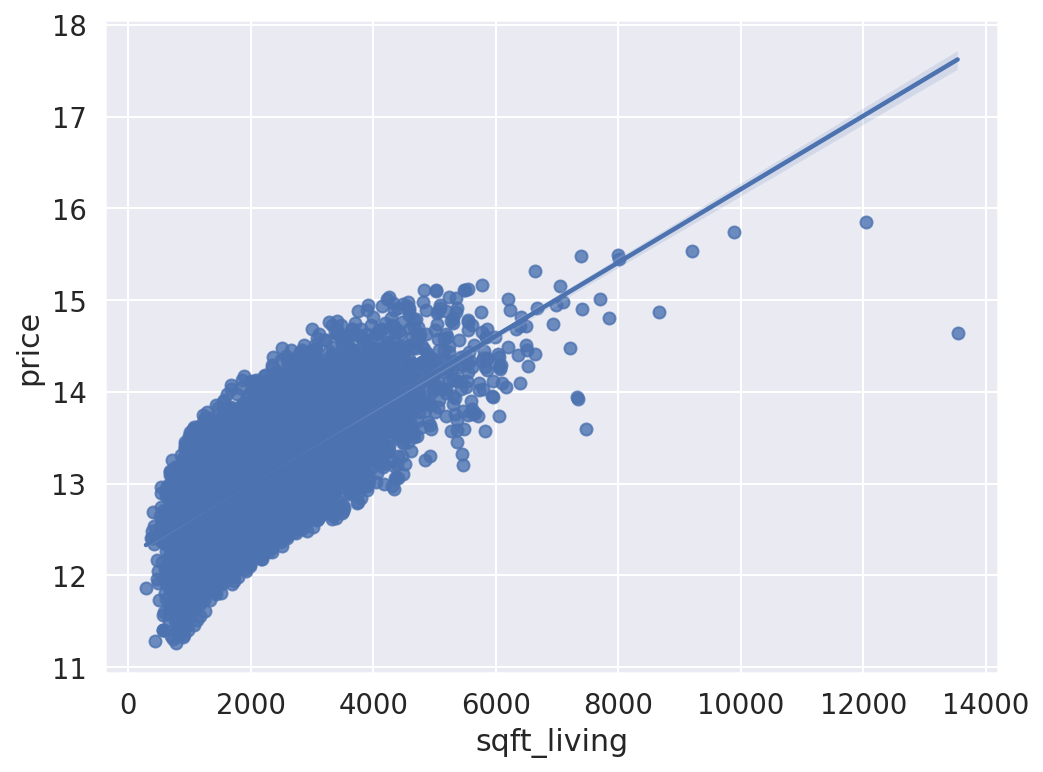

In [25]:
# price와 sqft_living
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [26]:
# 이상치 확인
train.loc[train['sqft_living'] > 13000]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
8912,8912,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,47.6675,-121.986,4850,217800


In [27]:
# 이상치 삭제
train = train.loc[train['id']!=8912]

### 정규화

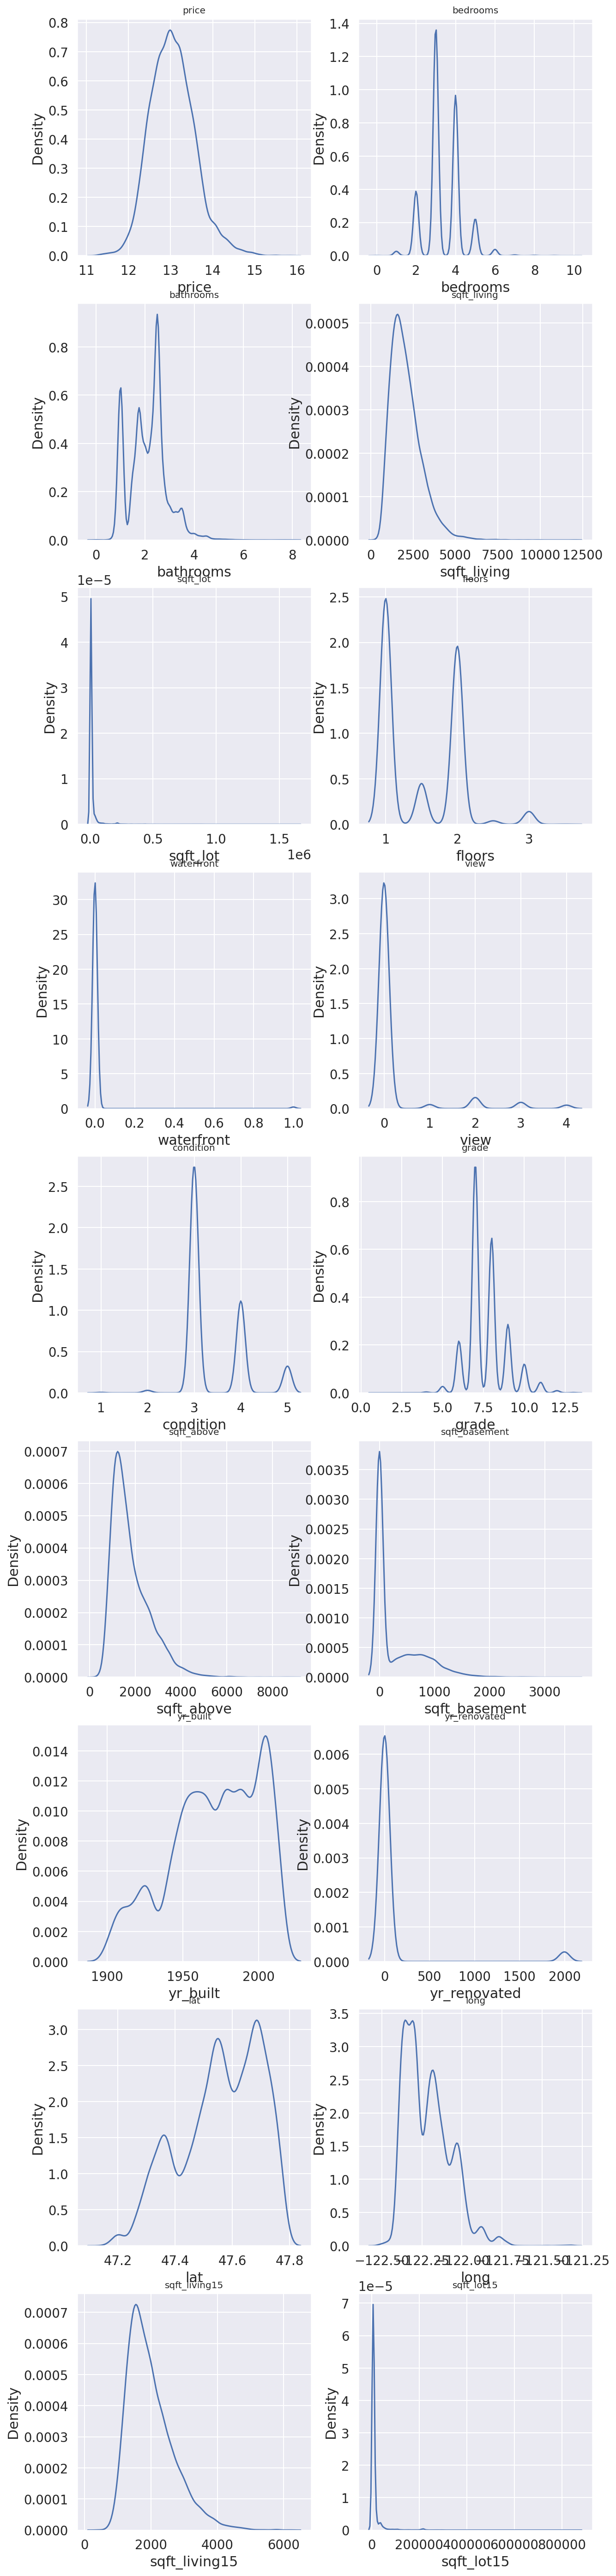

In [28]:
# 각 변수들의 분포 확인
fig, ax = plt.subplots(9, 2, figsize=(10, 50)) 

# id 변수(count==0인 경우)는 제외하고 분포를 확인
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        sns.set(font_scale=1.25)
        count += 1
        if count == 19 :
            break

In [29]:
# 로그 변환으로 정규화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

In [30]:
train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,0,12.309987,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,47.5112,-122.257,7.201171,8.639588
1,1,12.100718,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,47.7379,-122.233,7.908755,8.995041
2,2,13.142168,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,47.6168,-122.045,7.496097,8.923191
3,3,12.458779,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,47.3097,-122.327,7.713785,8.827615
4,4,12.583999,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,47.4095,-122.315,7.409136,9.181118


### 변수 정리

In [31]:
# 타겟 데이터 price를 y에 넣어두고 train에서 삭제하기
y = train['price']
del train['price']

# id 항목도 직접 연관이 없으므로 제거
del train['id']
del test['id']

print(train.columns)
print(test.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [32]:
# 학습 데이터 통계량 확인
train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000,15030.000000
mean,1.452926,2.114621,7.552231,8.992271,1.497971,0.006986,0.233666,3.406720,7.660812,7.397983,2.521182,1971.106919,83.561610,47.560725,-122.213737,7.542535,8.961580
std,0.210538,0.765467,0.424924,0.905276,0.538410,0.083293,0.762125,0.646354,1.177924,0.428805,3.166319,29.406518,399.857173,0.138149,0.141244,0.328622,0.813107
min,0.000000,0.000000,5.673323,6.255750,1.000000,0.000000,0.000000,1.000000,1.000000,5.673323,0.000000,1900.000000,0.000000,47.155900,-122.519000,5.991465,6.480045
25%,1.386294,1.750000,7.266129,8.522778,1.000000,0.000000,0.000000,3.000000,7.000000,7.082549,0.000000,1951.000000,0.000000,47.472700,-122.328000,7.307202,8.537192
50%,1.386294,2.250000,7.555382,8.938335,1.500000,0.000000,0.000000,3.000000,7.000000,7.359468,0.000000,1975.000000,0.000000,47.571900,-122.231000,7.523481,8.936890
75%,1.609438,2.500000,7.848153,9.276807,2.000000,0.000000,0.000000,4.000000,8.000000,7.710205,6.311735,1997.000000,0.000000,47.678300,-122.126000,7.766841,9.217788
max,2.397895,8.000000,9.396903,14.317110,3.500000,1.000000,4.000000,5.000000,13.000000,9.089415,8.155075,2015.000000,2015.000000,47.777600,-121.315000,8.734077,13.677628


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15030 entries, 0 to 15034
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15030 non-null  float64
 1   bathrooms      15030 non-null  float64
 2   sqft_living    15030 non-null  float64
 3   sqft_lot       15030 non-null  float64
 4   floors         15030 non-null  float64
 5   waterfront     15030 non-null  int64  
 6   view           15030 non-null  int64  
 7   condition      15030 non-null  int64  
 8   grade          15030 non-null  int64  
 9   sqft_above     15030 non-null  float64
 10  sqft_basement  15030 non-null  float64
 11  yr_built       15030 non-null  int64  
 12  yr_renovated   15030 non-null  int64  
 13  lat            15030 non-null  float64
 14  long           15030 non-null  float64
 15  sqft_living15  15030 non-null  float64
 16  sqft_lot15     15030 non-null  float64
dtypes: float64(11), int64(6)
memory usage: 2.1 MB


In [34]:
# 타겟 데이터 y(price)의 통계량 확인
y.describe()

count    15030.000000
mean        13.047790
std          0.526699
min         11.264477
25%         12.682310
50%         13.017005
75%         13.377007
max         15.856731
Name: price, dtype: float64

In [35]:
# price
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15030, dtype: float64

## 4. 모델링

### RMSE 계산

In [36]:
# 라이브러리 가져오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [37]:
# rmse 계산, 앞에서 로그함수로 y값을 변환해두었기 때문에 원래 데이터 단위로 바꿔주기 위해 np.expm1()을 추가
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [38]:
# 모델 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [39]:
random_state=2020    # 고정값 설정

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]    # 모델들을 models리스트에 넣어둔다

In [40]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [41]:
# 모델 별로 학습 및 예측

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,134727.255293
RandomForestRegressor,128923.607246
XGBRegressor,113768.350654
LGBMRegressor,111569.290180


In [42]:
# GridSearchCV 클래스 활용하여 실험
from sklearn.model_selection import GridSearchCV

In [43]:
# 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [44]:
# 모델 준비
model = LGBMRegressor(random_state=random_state)

In [45]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearch 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)
    
    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values(by=['RMSLE'])
    
    return results

In [46]:
# my_GridSearch() 함수로 간단한 그리드 탐색 해보기
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

# 가장 좋은 조합이 max_depth=10, n_estimators=100인 경우임을 알 수 있다
# 해당 모델로 학습을 해보자

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027747,0.166573
2,10,50,-0.029732,0.172431
1,1,100,-0.054972,0.234461
0,1,50,-0.073174,0.270506


In [47]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [48]:
save_submission(model, train, y, test, 'lgbm', rmsle='new')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_new.csv saved!


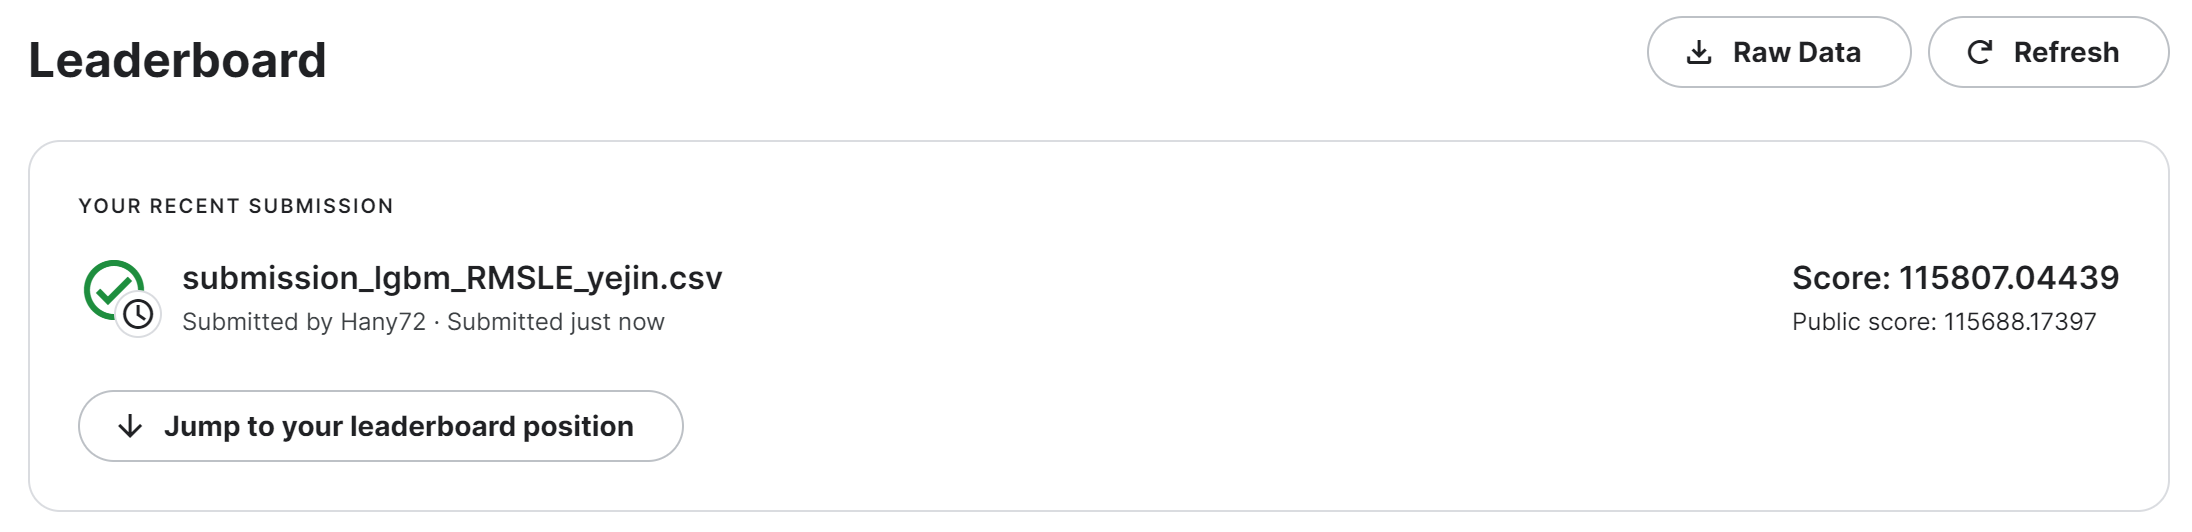

참고: <br>
https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook <br>
https://www.delftstack.com/ko/howto/seaborn/size-of-seaborn-heatmap/